In [ ]:
V7 -> trying to find out Age ranges vs loan_status didn't improve the score vs v6

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
!pip install autogluon thinc==8.2.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of spacy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to de

In [70]:
data = pd.read_csv('../input/playground-series-s4e10/train.csv')

In [32]:
data.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [49]:
data[(data['person_age']>70) & (data['person_age']<80)]

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,age_group
6425,6425,73,32004,MORTGAGE,3.0,PERSONAL,B,7500,10.65,0.24,N,23,0,"(70, 80]"
16954,16954,76,30000,RENT,2.0,HOMEIMPROVEMENT,D,6500,16.77,0.21,N,24,1,"(70, 80]"
24266,24266,73,40000,RENT,0.0,MEDICAL,B,1800,11.36,0.04,N,21,0,"(70, 80]"
25499,25499,73,42000,RENT,7.0,PERSONAL,D,13750,14.96,0.32,N,24,1,"(70, 80]"


/tmp/ipykernel_30/1635809111.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_status = data[data['loan_status'] == 1].groupby('age_group')['loan_status'].count().reset_index()
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


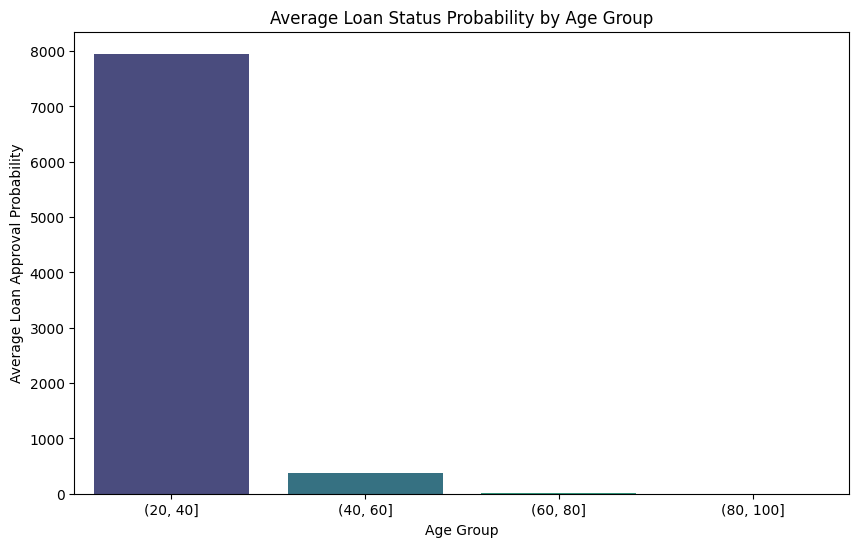

In [60]:
age_bins = [20, 40, 60,80,100]
data['age_group'] = pd.cut(data['person_age'], bins=age_bins)

# Calculate mean loan_status probability for each age bin
age_group_status = data[data['loan_status'] == 1].groupby('age_group')['loan_status'].count().reset_index()

# Plot the mean loan_status by age group
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='loan_status', data=age_group_status, palette='viridis')
plt.title("Average Loan Status Probability by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Loan Approval Probability")
plt.show()



In [72]:
age_bins = [20, 40, 60, 150]  # 100 as an upper bound for ages above 60
risk_labels = ['Low Risk', 'Mid Risk', 'High Risk']

# Use pd.cut to categorize ages into risk levels
data['risk_level'] = pd.cut(data['person_age'], bins=age_bins, labels=risk_labels)


In [73]:
# Set an assumed loan term in months, e.g., 36 months
assumed_loan_term_months = 36

# Calculate monthly interest rate
monthly_interest_rate = data['loan_int_rate'] / 12

# Calculate EMI using the given formula
emi = (data['loan_amnt'] * monthly_interest_rate * (1 + monthly_interest_rate)**assumed_loan_term_months) / \
            ((1 + monthly_interest_rate)**assumed_loan_term_months - 1)

# Calculate Monthly DTI Ratio
data['dti_ratio_monthly'] = emi / (data['person_income'] / 12)



# 5. Convert 'cb_person_default_on_file' (Y/N) to binary
data['cb_person_default_on_file'] = data['cb_person_default_on_file'].apply(lambda x: 1 if x == 'Y' else 0)

# 6. One-hot encode 'loan_intent' and 'person_home_ownership'
data = pd.get_dummies(data, columns=['loan_intent', 'person_home_ownership'], drop_first=True)

# 7. Bucket loan interest rate into categories (Low, Medium, High)
data['loan_int_rate_bucket'] = pd.cut(data['loan_int_rate'], bins=[0, 10, 15, 30], labels=['Low', 'Medium', 'High'])

# 8. Convert 'loan_grade' (assuming it is categorical A-F) to numerical values
loan_grade_mapping = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1, 'F': 0}
data['loan_grade'] = data['loan_grade'].map(loan_grade_mapping)

monthly_income = data['person_income']/12
data['in_hand_to_income_ratio'] = monthly_income-emi/monthly_income


In [74]:
data.columns

Index(['id', 'person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'loan_status', 'risk_level', 'dti_ratio_monthly',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_int_rate_bucket',
       'in_hand_to_income_ratio'],
      dtype='object')

In [75]:
from autogluon.tabular import TabularDataset, TabularPredictor

train_data = TabularDataset('../input/playground-series-s4e10/train.csv')
train_data = train_data.drop(columns=['id'])

label = 'loan_status'
predictor = TabularPredictor(label=label,eval_metric='roc_auc').fit(train_data)

Loaded data from: ../input/playground-series-s4e10/train.csv | Columns = 13 / 13 | Rows = 58645 -> 58645
No path specified. Models will be saved in: "AutogluonModels/ag-20241028_072045"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
Memory Avail:       29.61 GB / 31.36 GB (94.4%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accurac

[1000]	valid_set's binary_logloss: 0.162678


	0.9405	 = Validation score   (roc_auc)
	12.24s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: LightGBM ...
	0.9561	 = Validation score   (roc_auc)
	4.19s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9239	 = Validation score   (roc_auc)
	11.4s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9317	 = Validation score   (roc_auc)
	11.79s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: CatBoost ...
	0.9557	 = Validation score   (roc_auc)
	184.03s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9201	 = Validation score   (roc_auc)
	6.12s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9201	 = Validation score   (roc_auc)
	6.29s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.9284	 = Validation score   (roc_auc)
	82.68s	 = Training   runtime
	0.06s	 =

In [ ]:
performance = predictor.leaderboard()

In [ ]:
performance

In [ ]:
#best_predictor = TabularPredictor.load("AutogluonModels/ag-20241023_063409")
predictor.get_model_best()

In [76]:

test_data = pd.read_csv('../input/playground-series-s4e10/test.csv')
test_ids = test_data['id']

test_dataset = TabularDataset('../input/playground-series-s4e10/test.csv')
y_pred = predictor.predict_proba(test_dataset.drop(columns=['id']))

Loaded data from: ../input/playground-series-s4e10/test.csv | Columns = 12 / 12 | Rows = 39098 -> 39098


In [ ]:
y_pred

In [77]:
submission = pd.DataFrame({
    'id': test_ids,
    'loan_status': y_pred[1]
})
submission.to_csv('submission-v7.csv', index=False)